In [314]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.ticker as ticker
import pandas as pd
import glob
import re
# Statistics
from scipy.stats import norm
from scipy.special import factorial
# Parallel
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm

In [315]:
# Matplotlib customize
plt.rcParams['figure.figsize'] = [6,5]
plt.rcParams['figure.dpi'] = 100

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20

plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 4

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.markerscale'] = 1.5
plt.rcParams['legend.borderpad'] = 0.6
plt.rcParams['legend.framealpha'] = 0.7

In [316]:
Data = []
Mass = np.array([])

for f in glob.glob('Data/*.csv'):
    #print(f)
    
    data = pd.read_csv(f,sep=',')
    Data.append(data)

    # Extraer los últimos tres números del nombre del archivo
    match = re.search(r'(\d{3})\.csv$', f)
    if match:
        Mass = np.append(Mass, float(match.group(1)))

# Emparejar los numeros con los dataframes
paired = list(zip(Mass,Data))

# Ordenar los pares segun las masas
Mass_sorted = sorted(paired, key=lambda x: x[0])

# Separar de nuevo los numeros y los dataFrames
Mass_sorted, Data = zip(*Mass_sorted)

# Numpy array
Mass = np.array(Mass_sorted)

print(Mass)

[100. 106. 112. 118. 124. 130. 136. 142. 148. 154. 160.]


In [317]:
# Estimator definition
def GetLnQ(n,b,s,mu):
    return 2*(mu*s - n*np.log( 1 + (mu*s/b) ))

In [318]:
def GetJointLnQ(LnQ,mu,Null=True):

    Q = 0.

    for c in range(N):

        if Null:
            ntoy = np.random.poisson(b[c])
        else:
            ntoy = np.random.poisson( mu*s[c] + b[c] )

        Q += LnQ(ntoy,b[c],s[c],mu)

    return Q

In [319]:
def GetObsJointLnQ(LnQ,mu,Expected = True):

    Q = 0.
    
    for c in range(N):

        if Expected: # Observed events are the expected background
            Q += LnQ( b[c], b[c], s[c], mu )
        else:
            Q += LnQ( n[c], b[c], s[c], mu )

    return Q

In [346]:
def Sampler(mu, Ntoys = int(1e4)):

    q0 = np.zeros(Ntoys)
  
    for i in tqdm(range(Ntoys)):
        q0[i] = GetJointLnQ(GetLnQ, mu)  #H0
    
    return q0

In [347]:
data = Data[4]
labels = list(data.keys())
#n = np.array(data[labels[0]])
b = np.array(data[labels[1]])
s = np.array(data[labels[2]])
n = s+b
N = n.shape[0]

In [348]:
# Con significancia
Qobs = GetObsJointLnQ(GetLnQ,1.0,Expected = False)
Qobs

-21.04595409661052

In [349]:
q0 = Sampler(1.)

100%|█████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4019.77it/s]


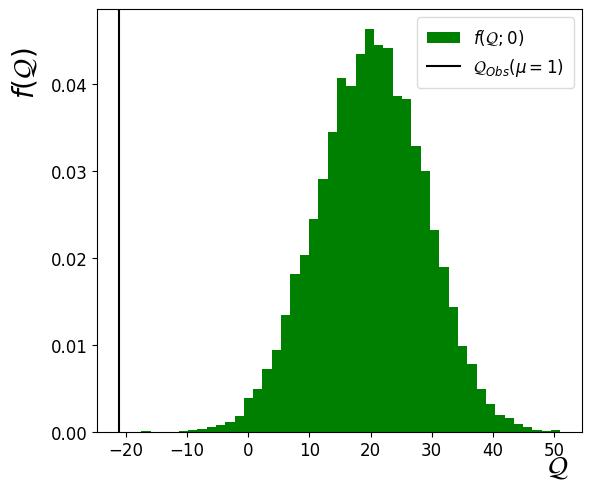

In [350]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(q0,bins=45,color='green',density=True,label=r'$f(\mathcal{Q};0)$')
plt.axvline(x=Qobs,color='k',label=r'$\mathcal{Q}_{Obs}(\mu=1)$')
#plt.yscale('log')

# Label X
ax.set_xlabel(r'$\mathcal{Q}$')
ax.xaxis.set_label_coords(0.95,-0.05)

# Label Y
ax.set_ylabel(r'$f(\mathcal{Q})$')
ax.yaxis.set_label_coords(-0.12,0.85)

# Ajustar los márgenes automáticamente
plt.tight_layout()

#Legend
ax.legend(loc='upper right',bbox_to_anchor=(1,1),ncol=1,title='')

#
#plt.savefig('Significance_Q.pdf')

In [351]:
def GetPValue(data,Qobs, Null = True):

    if Null:
        count_below_threshold = np.sum( data <= Qobs )
        p_value = count_below_threshold/data.shape[0]

    else:
        count_above_threshold = np.sum( data >= Qobs )
        p_value = count_above_threshold / data.shape[0]

    return p_value

In [352]:
p0 = GetPValue(q0,Qobs,Null = True)
#p1 = GetPValue(q1,Qobs,Null = False)
print(p0)

0.0


In [353]:
Significancia = np.abs(norm.ppf(p0))
Significancia

inf

In [354]:
# Funcion en paralelo
def GetCls_for_mu(i, mu, Expected = False):

    Qobs = GetObsJointLnQ(GetLnQ,1,Expected)
    q0,q1 = Sampler(mu)
    
    p0 = GetPValue(q0, Qobs, Null = True)
    p1 = GetPValue(q1, Qobs, Null = False)

    Clb = 1 - p0
    Clsb = p1

    Cls = Clsb/Clb

    return i,Clsb

In [355]:
def GetCls_parallel(mu, Expected=False, num_processors=None):

    p_value = np.zeros_like(mu)

    with ProcessPoolExecutor(max_workers=num_processors) as executor:

        futures = np.array([])

        # Crear las tareas (futuras) para cada valor de mu
        for i in range(mu.shape[0]):

            futures = np.append(futures,executor.submit(GetCls_for_mu, i, mu[i], Expected))

        # Recolectar los resultados a medida que se completan
        for future in tqdm(as_completed(futures), total=len(futures)):
            i, Clsb = future.result()
            p_value[i] = Clsb

    return p_value

In [356]:
# Estructura de datos para guardar
MatrizDatos = np.zeros((Mass.shape[0],3))
MatrizDatos[:,0] = Mass
MatrizDatos

array([[100.,   0.,   0.],
       [106.,   0.,   0.],
       [112.,   0.,   0.],
       [118.,   0.,   0.],
       [124.,   0.,   0.],
       [130.,   0.,   0.],
       [136.,   0.,   0.],
       [142.,   0.,   0.],
       [148.,   0.,   0.],
       [154.,   0.,   0.],
       [160.,   0.,   0.]])

In [363]:
# Running the upper limits for each signal points

for i, data in enumerate(Data):

    print('--- Estimating Limits for ---', Mass[i])
    labels = list(data.keys())
    n = np.array(data[labels[0]])
    b = np.array(data[labels[1]])
    s = np.array(data[labels[2]])
    n = s+b # Para la significancia
   
    N = n.shape[0]

    Qobs = GetObsJointLnQ(GetLnQ,1.0,Expected = False)    
    q0 = Sampler(1.)
    
    p0 = GetPValue(q0,Qobs,Null = True)
    Significance = np.abs(norm.ppf(p0))
    
    if p0 == 0:
        print('Se necesita más toy experiments', i)

        MatrizDatos[i,1] = 1e-8
        MatrizDatos[i,2] = np.abs(norm.ppf(1e-8))
    
    else:
        MatrizDatos[i,1] = p0
        MatrizDatos[i,2] = Significance

--- Estimating Limits for --- 100.0


100%|█████████████████████████████████████████████| 10000/10000 [00:02<00:00, 3866.23it/s]


--- Estimating Limits for --- 106.0


100%|█████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4013.15it/s]


--- Estimating Limits for --- 112.0


100%|█████████████████████████████████████████████| 10000/10000 [00:02<00:00, 3987.33it/s]


--- Estimating Limits for --- 118.0


100%|█████████████████████████████████████████████| 10000/10000 [00:02<00:00, 3933.89it/s]


Se necesita más toy experiments 3
--- Estimating Limits for --- 124.0


100%|█████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4110.10it/s]


Se necesita más toy experiments 4
--- Estimating Limits for --- 130.0


100%|█████████████████████████████████████████████| 10000/10000 [00:02<00:00, 3920.45it/s]


Se necesita más toy experiments 5
--- Estimating Limits for --- 136.0


100%|█████████████████████████████████████████████| 10000/10000 [00:02<00:00, 3690.83it/s]


Se necesita más toy experiments 6
--- Estimating Limits for --- 142.0


100%|█████████████████████████████████████████████| 10000/10000 [00:03<00:00, 3014.19it/s]


Se necesita más toy experiments 7
--- Estimating Limits for --- 148.0


100%|█████████████████████████████████████████████| 10000/10000 [00:03<00:00, 3090.19it/s]


Se necesita más toy experiments 8
--- Estimating Limits for --- 154.0


100%|█████████████████████████████████████████████| 10000/10000 [00:03<00:00, 2865.09it/s]


Se necesita más toy experiments 9
--- Estimating Limits for --- 160.0


100%|█████████████████████████████████████████████| 10000/10000 [00:02<00:00, 3902.86it/s]

Se necesita más toy experiments 10


In [364]:
DataFinal = pd.DataFrame(MatrizDatos)
DataFinal.columns = ['Mass','p0','Significance']
DataFinal

,Mass,p0,Significance
0,100.0,1.220000e-02,2.250772
1,106.0,1.000000e-04,3.719016
2,112.0,1.000000e-04,3.719016
3,118.0,1.000000e-08,5.612001
4,124.0,1.000000e-08,5.612001
5,130.0,1.000000e-08,5.612001
6,136.0,1.000000e-08,5.612001
7,142.0,1.000000e-08,5.612001
8,148.0,1.000000e-08,5.612001
9,154.0,1.000000e-08,5.612001


In [365]:
DataFinal.to_csv('SignificanceMassScan.csv',index=False)

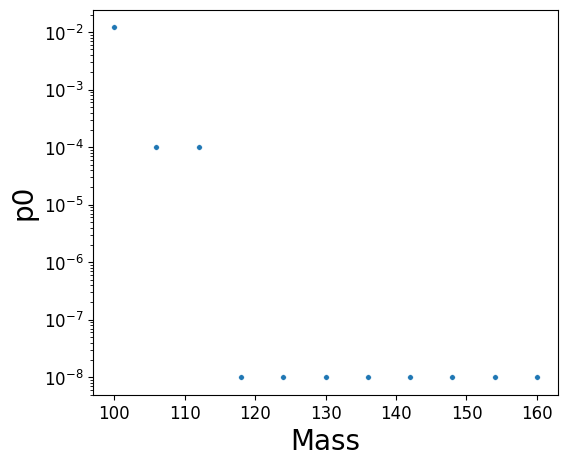

In [366]:
import seaborn as sns
sns.scatterplot(x='Mass',y='p0',data = DataFinal)
plt.yscale('log')